In [188]:
import pandas as pd
import numpy as np
from typing import Set, Dict, List
import json
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt

In [132]:
SelectedGenres: List[str] = ['Science Fiction', 'Action', 'Drama', 'Thriller', 'Adventure', 'Fantasy', 'Comedy', 'Horror']

In [121]:
# ratings = pd.read_csv('../data/ratings_small.csv')
ratings = pd.read_csv('../data/ratings_small.csv')
metadata = pd.read_csv('../data/movies_metadata.csv');
ratings.head()

/home/sigma/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [122]:
ratings.groupby('userId').count()

,movieId,rating,timestamp
userId,,,
1,20,20,20
2,76,76,76
3,51,51,51
4,204,204,204
5,100,100,100
...,...,...,...
667,68,68,68
668,20,20,20
669,37,37,37


Number of users that ranked at least 50 movies, but less than 300 {tmp.size}


<AxesSubplot:>

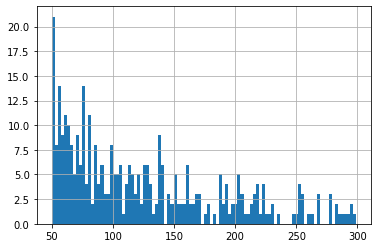

In [123]:
tmp = ratings.groupby('userId')['rating'].count()
tmp = tmp[(tmp >= 50) & (tmp < 300)]
print("""Number of users that ranked at least 50 movies, but less than 300 {tmp.size}""")
tmp.hist(bins=100)

In [124]:
percentileCutoff: float = metadata.vote_count.quantile(0.7)
metadata = metadata[metadata['vote_count'] >= percentileCutoff]
metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45380,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",https://www.netflix.com/title/80171022,432789,tt5990342,en,The Incredible Jessica James,"Burned by a bad breakup, a struggling New York...",...,2017-01-27,0.0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Likes are easy, love is hard.",The Incredible Jessica James,False,6.2,37.0
45437,False,NaN,0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",NaN,455661,tt6969946,en,In a Heartbeat,A closeted boy runs the risk of being outed by...,...,2017-06-01,0.0,4.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Heart Wants What The Heart Wants,In a Heartbeat,False,8.3,146.0
45441,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,14008,tt0294425,en,Cadet Kelly,Hyperactive teenager Kelly is enrolled into a ...,...,2002-03-07,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Too Cool For The Rules!,Cadet Kelly,False,5.2,145.0
45443,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",NaN,49279,tt0000359,fr,L'Homme à la tête de caoutchouc,A chemist in his laboratory places upon a tabl...,...,1901-01-01,0.0,3.0,[],Released,NaN,The Man with the Rubber Head,False,7.6,29.0


In [169]:
class CMovie:
    def __init__(self, id: str, title: str, genres: Set[str]):
        self.id = id
        self.title = title
        self.genres = genres

    def isGenre(self, genre: str):
        return genre in self.genres

    @staticmethod
    def extractGenres(rawObject: str) -> Set[str]:
        result: Set[str] = set()
        arr = literal_eval(rawObject)
        for genre in arr:
            result.add(genre['name'])
        return result

class CUser:
    def __init__(self, id: int) -> None:
        self.id = id
        self.countByGenre: Dict[str, float] = defaultdict(float)
        self.zScoreByGenre: Dict[str, float] = defaultdict(float)
        self.totalRatings = None
        self.totalZScore = None

    def countRatingsByGenres(self, ratingsDf, Movies: Dict[str, CMovie]):
        self.countByGenre = defaultdict(int)
        self.totalRatings = 0;
        # TODO highly ineffective - scans all ratings for each user
        for index, row in ratingsDf[ratingsDf.userId == self.id].iterrows():
            if row.movieId not in Movies:
                continue
            for genre in Movies[row.movieId].genres:
                self.countByGenre[genre] += 1 / len(Movies[row.movieId].genres)
                self.totalRatings +=1

In [170]:
Movies: Dict[str, CMovie] = {}

for index, row in metadata.iterrows():
    Movies[row.id] = CMovie(
        id=row.imdb_id,
        title=row.title,
        genres=CMovie.extractGenres(row.genres)
    )

len(Movies)

Users: Dict[int, CUser] = {}
for index, row in ratings.iterrows():
    if row.userId not in Users:
        Users[row.userId] = CUser(id=row.userId)

In [171]:
usersTotalRatings = []
for user in Users.values():
    user.countRatingsByGenres(ratings, Movies)
    usersTotalRatings.append(user.totalRatings)

count     671.000000
mean      134.847988
std       181.454935
min         5.000000
25%        41.500000
50%        73.000000
75%       155.500000
max      1911.000000
dtype: float64
count    535.000000
mean      96.185047
std       65.966180
min       22.000000
25%       45.000000
50%       73.000000
75%      131.500000
max      281.000000
dtype: float64


<AxesSubplot:>

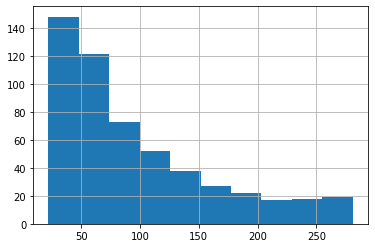

In [172]:
# constructing scale based only on number of watched movies
tmpSeries = pd.Series(usersTotalRatings)
print(tmpSeries.describe())
minThreshold = tmpSeries.quantile(0.1)
maxThreshold = tmpSeries.quantile(0.9)
tmpSeries = tmpSeries[(tmpSeries > minThreshold) & (tmpSeries < maxThreshold)]
print(tmpSeries.describe())
tmpSeries.hist()

Science Fiction 

count    671.000000
mean       0.016982
std        0.010495
min        0.000000
25%        0.011546
50%        0.015815
75%        0.020758
max        0.083333
dtype: float64


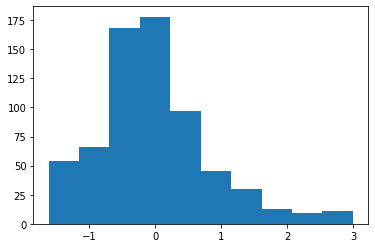

Action 

count    671.000000
mean       0.028131
std        0.011400
min        0.000000
25%        0.022602
50%        0.027451
75%        0.031895
max        0.125000
dtype: float64


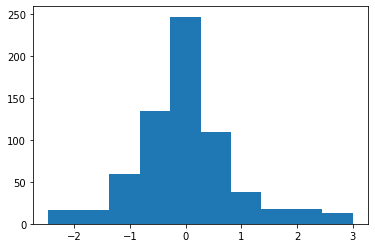

Drama 

count    671.000000
mean       0.110366
std        0.031574
min        0.000000
25%        0.092987
50%        0.106643
75%        0.125000
max        0.293478
dtype: float64


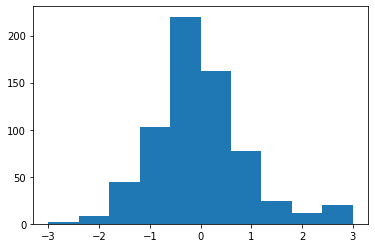

Thriller 

count    671.000000
mean       0.038565
std        0.014890
min        0.000000
25%        0.031145
50%        0.037179
75%        0.043301
max        0.166667
dtype: float64


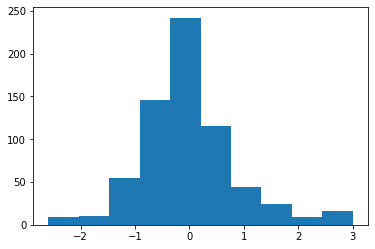

Adventure 

count    671.000000
mean       0.019684
std        0.010298
min        0.000000
25%        0.014366
50%        0.019174
75%        0.024025
max        0.095238
dtype: float64


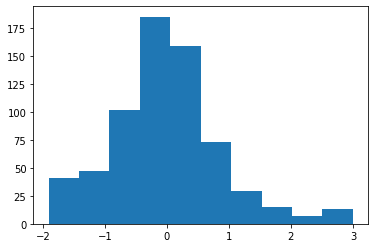

Fantasy 

count    671.000000
mean       0.011489
std        0.007624
min        0.000000
25%        0.007353
50%        0.011218
75%        0.015292
max        0.047619
dtype: float64


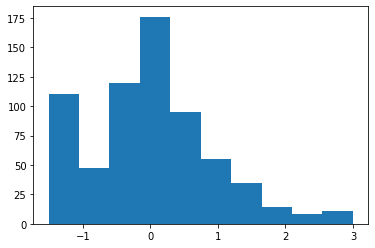

Comedy 

count    671.000000
mean       0.050731
std        0.025360
min        0.000000
25%        0.035994
50%        0.047830
75%        0.059112
max        0.228571
dtype: float64


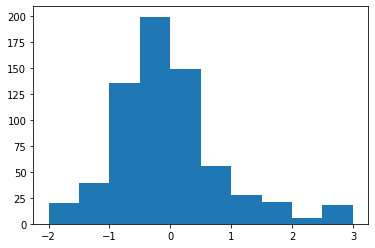

Horror 

count    671.000000
mean       0.013989
std        0.011928
min        0.000000
25%        0.006536
50%        0.012528
75%        0.019685
max        0.083333
dtype: float64


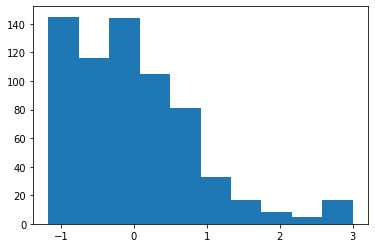

In [192]:
for GENRE_NAME in SelectedGenres:
    tmpSeries = []

    print(GENRE_NAME, "\n")

    for user in Users.values():
        tmpSeries.append(user.countByGenre[GENRE_NAME]/user.totalRatings)

    tmpSeries = pd.Series(tmpSeries)
    print(tmpSeries.describe())

    mean = tmpSeries.mean()
    std = tmpSeries.std()
    for user in Users.values():
        tmpZScore = (user.countByGenre[GENRE_NAME]/user.totalRatings - mean) / std
        tmpZScore = min(tmpZScore, 3)
        tmpZScore = max(tmpZScore, -3)
        user.zScoreByGenre[GENRE_NAME] = tmpZScore

    plot = plt.hist(pd.Series(map(lambda user: user.zScoreByGenre[GENRE_NAME], Users.values())))
    plt.show()

0      0.000000
1      0.025397
2      0.022321
3      0.029552
4      0.028741
         ...   
666    0.029195
667    0.046667
668    0.010753
669    0.010465
670    0.027451
Length: 671, dtype: float64

In [ ]:
########################################################################################

In [135]:
ratings.movieId = ratings.movieId.astype(str)
tmpMask = ratings.movieId.isin(Movies.keys())
ratings = ratings[tmpMask]
ratings

,userId,movieId,rating,timestamp
10,1,1371,2.5,1260759135
11,1,1405,1.0,1260759203
13,1,2105,4.0,1260759139
16,1,2294,2.0,1260759108
17,1,2455,2.5,1260759113
...,...,...,...,...
99978,671,4886,5.0,1064245488
99981,671,4973,4.5,1064245471
99983,671,4995,4.0,1064891537
99993,671,5902,3.5,1064245507


In [128]:
genresHist = defaultdict(int)
for movie in Movies.values():
    for genre in movie.genres:
        genresHist[genre] += 1
genresHist

defaultdict(int,
            {'Comedy': 4760,
             'Family': 1250,
             'Animation': 911,
             'Fantasy': 1121,
             'Adventure': 1763,
             'Romance': 2229,
             'Drama': 6512,
             'Crime': 1843,
             'Thriller': 3546,
             'Action': 2895,
             'Horror': 2005,
             'History': 514,
             'Science Fiction': 1436,
             'Mystery': 1015,
             'War': 418,
             'Music': 437,
             'Documentary': 440,
             'Foreign': 63,
             'Western': 248,
             'TV Movie': 144})

In [136]:
len(Users)

671

In [130]:
ratings.dtypes

userId         int64
movieId       object
rating       float64
timestamp      int64
dtype: object